# W4_Implementing EM for Gaussian Mixtures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import copy
from scipy.stats import multivariate_normal # multivariate Gaussian distribution
# image handling library
from PIL import Image
from PIL import ImageStat
from io import BytesIO
import os
import csv

In [2]:
def loglikelihood(X, weights, means, covs):
    '''Compute the loglikelihood of the X for a Gaussian mixture model with the given parameters'''
    num_clusters = len(weights)
    num_dim = len(X[0])
    
    ll = 0
    for x in X:
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            delta = np.array(x) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        ll += np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))
        
    return ll

In [3]:
def compute_responsibilities(X, weights, means, covariances):
    '''compute responsibilities, given the current parameters'''
    num_data = len(X) # n
    num_clusters = len(weights) # k
    resp = np.zeros((num_data, num_clusters)) # n* k
    
    # update resp matrix so that resp[i,k] is the responsibility of cluster k for X point i
    for i in range(num_data):
        for k in range(num_clusters):
            resp[i, k] =  weights[k] * multivariate_normal.pdf(X[i], mean=means[k], cov=covariances[k]) 
    
    # add up responsibilities over each X point and normalize
    for i in range(num_data):
        total = sum(resp[i])
        resp[i] = resp[i] / total

    return resp

In [4]:
def compute_soft_counts(resp):
    '''compute soft counts'''
    counts = np.sum(resp, axis=0) # 1*k
    return counts

In [5]:
def compute_weights(counts):
    '''update weights'''
    num_clusters = len(counts) # k
    weights = np.zeros(num_clusters) # 1*k
    
    for k in range(num_clusters):
        weights[k] = counts[k] / sum(counts)

    return weights

In [6]:
def compute_means(X, resp, counts):
    '''update means'''
    num_clusters = len(counts) # k
    num_data = len(X) # n
    num_dim = len(X[0]) # d
    means = [np.zeros(num_dim)] * num_clusters
    
    for k in range(num_clusters):
        weighted_sum = 0.
        for i in range(num_data):
            weighted_sum += resp[i, k] * X[i]
        means[k] = weighted_sum / counts[k]

    return means

In [7]:
def compute_covariances(X, resp, counts, means):
    '''update covarienves'''
    num_clusters = len(counts) # k
    num_data = len(X) # n
    num_dim = len(X[0]) # d
    covariances = [np.zeros((num_dim, num_dim))] * num_clusters
    
    for k in range(num_clusters):
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            weighted_sum += resp[i, k] * np.outer(X[i]-means[k], X[i]-means[k])
        covariances[k] = weighted_sum / counts[k]

    return covariances

In [8]:
def EM(X, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    '''expectation–maximization algorithm'''
    # make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    num_data = len(X)
    num_dim = len(X[0])
    num_clusters = len(means)
    
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(X, weights, means, covariances)
    ll_trace = [ll]
    
    for iteration in range(maxiter):
        
        # E-step
        resp = compute_responsibilities(X, weights, means, covariances) # compute responsibilities

        # M-step
        counts = compute_soft_counts(resp) # compute the total responsibility assigned to each cluster
        weights = compute_weights(counts) # update the weight 
        means = compute_means(X, resp, counts) # update means
        covariances = compute_covariances(X, resp, counts, means) # update covariances
    
        ll_latest = loglikelihood(X, weights, means, covariances)
        ll_trace.append(ll_latest)
        # check for convergence 
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    print("Total iteration: %s" % (iteration+1))
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [9]:
def generate_MoG_data(num_data, means, covariances, weights):
    num_clusters = len(means)
    data = []
    for i in range(num_data):
        k = np.random.choice(num_clusters, 1, p=weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data.append(x)
    return data

In [10]:
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]

init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]

init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

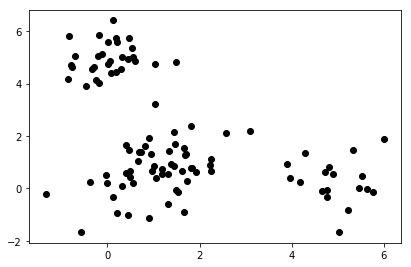

In [11]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [12]:
np.random.seed(4)

# initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3
 
results = EM(data, initial_means, initial_covs, initial_weights)

Total iteration: 23


In [13]:
results['weights']

array([ 0.30071023,  0.1799371 ,  0.51935267])

In [14]:
results['means']

[array([ 0.02138285,  4.947729  ]),
 array([ 4.94239235,  0.31365311]),
 array([ 1.08181125,  0.73903508])]

In [15]:
results['covs']

[array([[ 0.2932614 ,  0.05048455],
        [ 0.05048455,  0.35281537]]), array([[ 0.3556437 , -0.01494875],
        [-0.01494875,  0.66695025]]), array([[ 0.67114992,  0.33058965],
        [ 0.33058965,  0.90429724]])]

In [16]:
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

Total iteration: 12
Total iteration: 23


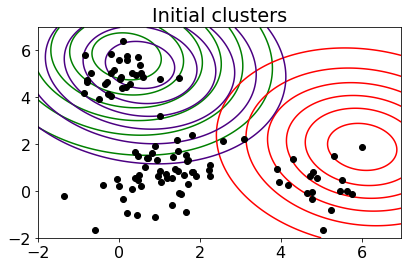

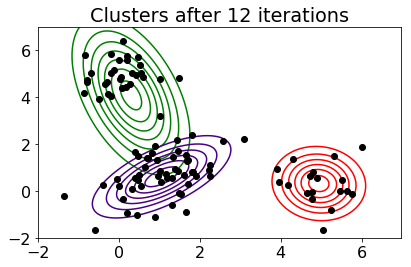

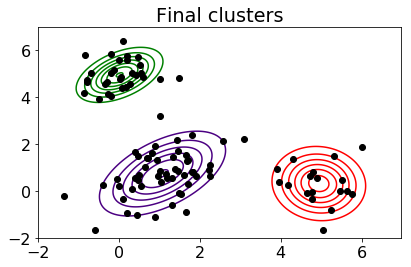

In [17]:
# parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

# parameters after 12 iterations
results = EM(data, initial_means, initial_covs, initial_weights, 12)
plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

# parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

Total iteration: 23


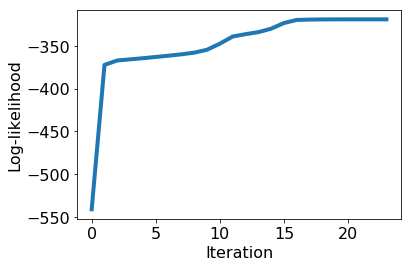

In [18]:
results = EM(data, initial_means, initial_covs, initial_weights)
loglikelihoods = results['loglik']

plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [19]:
# import the photos
rgb_picture_array = []
for folder in os.listdir('images'):
    for filename in os.listdir('images/'+folder):
        if filename.endswith(".jpg"): 
            im = Image.open('images/'+folder+'/'+filename)
            # get RGB mean values per image
            means = ImageStat.Stat(im).mean
            # store filename and RGB Values
            rgb_picture_array.append( (filename, np.array(means)/256) )

# create the dataframe
images = pd.DataFrame(rgb_picture_array)
images.columns=['filename', 'rgb']
images['red'] = images['rgb'].apply(lambda row: row[0])
images['green'] = images['rgb'].apply(lambda row: row[1])
images['blue'] = images['rgb'].apply(lambda row: row[2])

# sort the dataframe to match the SFrame provided for the course
with open('ordered_filenames.csv', 'rt') as file:
    reader = csv.reader(file)
    paths = paths = np.array(list(reader)).flatten()

images['filename'] = images['filename'].astype('category')
images['filename'].cat.set_categories(paths, inplace=True)
images = images.sort_values(['filename'])

images.head()

,filename,rgb,red,green,blue
888,ANd9GcSN4TPL6_XoTvZeg3-15UhGnWAwjhbxQLjTNiCpWI...,"[0.402697711634, 0.254471982222, 0.29761650803]",0.402698,0.254472,0.297617
669,ANd9GcQeme67tTCcvFbjg3xtvKPls3300iLBXVDEUfy8mx...,"[0.55500352329, 0.246767155594, 0.0481496661426]",0.555004,0.246767,0.048150
852,ANd9GcSAb2GMlHYIvV8eXZuUskgqHA-Oo2LfLjw3FsyeSD...,"[0.529754098361, 0.11515454235, 0.0742614412568]",0.529754,0.115155,0.074261
802,ANd9GcRs4-CSokZQJFe9vodGC6fK7ouonFopisgxltdHeL...,"[0.456548189148, 0.194264398709, 0.614741646744]",0.456548,0.194264,0.614742
696,ANd9GcQov2JpsVI0UO50J4NiyhsuxMNw90ffXe6U7PCHVJ...,"[0.329334454822, 0.231584799226, 0.202982016392]",0.329334,0.231585,0.202982


In [20]:
np.random.seed(1)

# initialize parameters
init_means = [images['rgb'][x] for x in np.random.choice(len(images), 4, replace=False)]
cov = np.diag([images['red'].var(), images['green'].var(), images['blue'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# convert rgb data to numpy arrays
img_data = [np.array(i) for i in images['rgb']]  

# run our EM algorithm on the image data using the above initializations
out = EM(img_data, init_means, init_covariances, init_weights)

Total iteration: 83


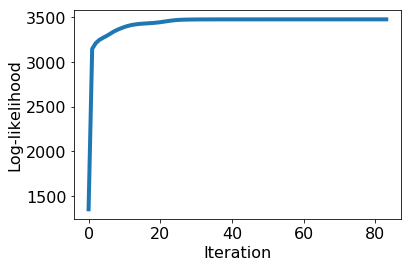

In [21]:
# evaluating convergence
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [22]:
weights = out['weights']
means = out['means']
covariances = out['covs']
rgb = images['rgb']
N = len(images) # number of images
K = len(means) # number of clusters

assignments = [0]*N
probs = [0]*N

for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    p = np.zeros(K)
    for k in range(K):
        p[k] = weights[k]*multivariate_normal.pdf(rgb[i], mean=means[k], cov=covariances[k])
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment:
    probs[i] = np.max(p)

assignments = pd.DataFrame({'assignments':assignments, 'probs':probs})

In [23]:
assignments.head()

,assignments,probs
0,3,100.629895
1,0,6.107061
2,0,6.986321
3,3,110.964451
4,3,121.896292
